In [12]:
from pydicom import dcmread
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import nibabel as nib
import SimpleITK as sitk
from helpers import *
import skimage.transform as skTrans
from PIL import Image
from matplotlib.colors import ListedColormap

### Load Segmentation folder

In [6]:
seg_imgs = []
folder_seg_path = "D:/Documents/GitHub/VascuIAR/DeepLearning/data/VnRawData/VHSCDD_sep_labels/VHSCDD_020_label/"
for file in os.listdir(folder_seg_path):
    if file.endswith('.nii.gz'):
        img_raw = sitk.ReadImage(folder_seg_path + file, sitk.sitkFloat32)
        seg_imgs.append(sitk.GetArrayFromImage(img_raw))

In [7]:
explore_3D_array(seg_imgs[3])

interactive(children=(IntSlider(value=255, description='SLICE', max=511), Output()), _dom_classes=('widget-int…

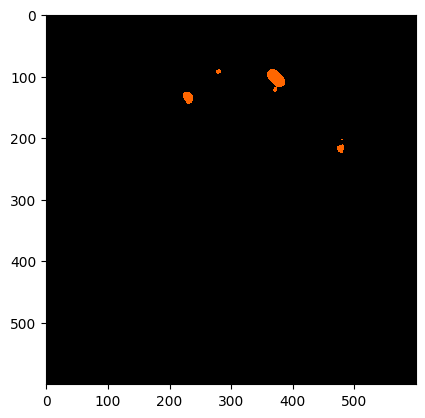

In [14]:
arr = seg_imgs[3][255,:,:]

# Define the hex color you want
hex_color = "#ff6600"

# Convert the hex color to RGB values in the range [0, 1]
rgb_color = np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)]) / 255.

# Create a custom colormap that maps 0. to black and 1. to your color
cmap = ListedColormap([np.array([0., 0., 0.]), rgb_color])

# Plot the array using the custom colormap
plt.imshow(arr, cmap=cmap)
plt.show()

In [15]:
print(rgb_color)

[1.  0.4 0. ]


### Filtering

In [22]:
'''
0: background
1: vena cava
2: auricle
3: coronary
4: left ventricle
5: right ventricle
6: left atrium
7: right atrium
8: myocardiuum
9: descending aorta
10: pulmonmary trunk
11: ascending aorta
'''

array_1d = seg_imgs[8].flatten()
unique_values, counts = np.unique(array_1d, return_counts=True)
print("Unique values:", unique_values) 
print("Counts:", counts)

Unique values: [0.0000000e+00 1.0848045e-05 1.2576580e-05 ... 4.9921875e+00 4.9960938e+00
 5.0000000e+00]
Counts: [182417707         1         1 ...      1730      1538   1457911]


In [ ]:
class filtering:
    def __init__(self, segmentation): 
        self.segmentation=segmentation
        
    def get(self):
        array_1d = self.segmentation.flatten()
        unique_values, counts = np.unique(array_1d, return_counts=True)
        label_arrays = []
        for value in unique_values: 
            label_array = np.copy(self.segmentation) 
            # label_array[np.where(label_array != value)] = 0 
            label_array = np.where(label_array==value, label_array, 0)
            
            label_arrays.append(label_array)
        return label_arrays
            
seg_raw = sitk.ReadImage("D:/Documents/GitHub/VascuIAR/DeepLearning/data/MM_WHS/seg_res/1006/Segmentation.nii", sitk.sitkFloat32)
seg = sitk.GetArrayFromImage(seg_raw)
filtering_instance = filtering(seg)
label_arrays = filtering_instance.get()
explore_3D_array(label_arrays[2])
label_arrays[2].shape

### Confirm Image and Segmentaionn

In [ ]:
path_img = "D:\Documents\GitHub\VascuIAR\DeepLearning\data\VnRawData\TrainData\ct_0086_image.nii.gz"
path_seg = "D:\Documents\GitHub\VascuIAR\DeepLearning\data\VnRawData\SegmentationData\ct_0087_label.nii.gz"

img_raw = sitk.ReadImage(path_img, sitk.sitkFloat32)
img = sitk.GetArrayFromImage(img_raw)
seg_raw = sitk.ReadImage(path_seg, sitk.sitkFloat32)
seg = sitk.GetArrayFromImage(seg_raw)
print(img.shape, seg.shape)
explore_3D_array_comparison(img, seg)

### Resize image after confirmation

In [12]:
def ResizeImage(image, x_, y_,z_):
    return np.array(skTrans.resize(image, (x_, y_, z_), order=1, preserve_range=True, anti_aliasing=False), dtype="float16")

def SaveImage(image, file_path_save):
    converted_array = np.array(image, dtype=np.float32)
    converted_array = np.transpose(converted_array, (2, 1, 0))
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)
    nib.save(nifti_file, file_path_save)
    
img = ResizeImage(img, 512, 600, 600)
SaveImage(img, "D:\Documents\GitHub\VascuIAR\DeepLearning\data\VnRawData\TrainDataResized\ct_0013_label.nii.gz")